In [100]:
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
#setting up gdrive for colab
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### clustering


In [74]:
data_dir = 'drive/My Drive/Hackathon/instacart_2017_05_01/'

In [75]:
orders = pd.read_csv(data_dir + 'orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [76]:
prior = pd.read_csv(data_dir + 'order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [77]:
train = pd.read_csv(data_dir+'order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [78]:
complete_train = pd.merge(train,orders[['order_id','user_id']], left_on = 'order_id', right_on = 'order_id', how = 'left')

In [79]:
complete_train

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108
...,...,...,...,...,...
1384612,3421063,14233,3,1,169679
1384613,3421063,35548,4,1,169679
1384614,3421070,35951,1,1,139822
1384615,3421070,16953,2,1,139822


In [80]:
complete_prior = pd.merge(prior,orders[['order_id','user_id']], left_on = 'order_id', right_on = 'order_id', how = 'left')

In [81]:
complete_prior.user_id.unique().shape

(206209,)

In [82]:
sub = pd.read_csv(data_dir+'sample_submission.csv')

In [84]:
complete_train_sample = complete_train[complete_train['user_id'] == 112108]

In [86]:
complete_prior_sample = complete_prior[complete_prior['user_id'] == 112108]
complete_prior_sample

,order_id,product_id,add_to_cart_order,reordered,user_id
1770588,186706,14947,1,1,112108
1770589,186706,5707,2,1,112108
1770590,186706,44632,3,0,112108
1770591,186706,30881,4,1,112108
1770592,186706,43633,5,1,112108
13529737,1427983,42001,1,0,112108
13529738,1427983,43633,2,0,112108
13529739,1427983,30881,3,0,112108
13529740,1427983,49302,4,0,112108
13529741,1427983,22035,5,0,112108


In [88]:
product = pd.read_csv(data_dir + 'products.csv')
complete_prior_sample = pd.merge(complete_prior_sample, product[['product_name','product_id','department_id']], 
                                 left_on = 'product_id', right_on = 'product_id', how = 'left')
complete_prior_sample

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name_x,department_id_x,product_name_y,department_id_y
0,186706,14947,1,1,112108,Pure Sparkling Water,7,Pure Sparkling Water,7
1,186706,5707,2,1,112108,Dark Chocolate Cinnamon Pecan Bar,19,Dark Chocolate Cinnamon Pecan Bar,19
2,186706,44632,3,0,112108,Sparkling Water Grapefruit,7,Sparkling Water Grapefruit,7
3,186706,30881,4,1,112108,Naturally Smoked Oysters in Pure Olive Oil,15,Naturally Smoked Oysters in Pure Olive Oil,15
4,186706,43633,5,1,112108,Lightly Smoked Sardines in Olive Oil,15,Lightly Smoked Sardines in Olive Oil,15
5,1427983,42001,1,0,112108,"Tuna Ventresca, in Olive Oil",15,"Tuna Ventresca, in Olive Oil",15
6,1427983,43633,2,0,112108,Lightly Smoked Sardines in Olive Oil,15,Lightly Smoked Sardines in Olive Oil,15
7,1427983,30881,3,0,112108,Naturally Smoked Oysters in Pure Olive Oil,15,Naturally Smoked Oysters in Pure Olive Oil,15
8,1427983,49302,4,0,112108,Bulgarian Yogurt,16,Bulgarian Yogurt,16
9,1427983,22035,5,0,112108,Organic Whole String Cheese,16,Organic Whole String Cheese,16


In [89]:
aisles = pd.read_csv(data_dir + 'aisles.csv')
prior = prior[0:300000]
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
_mt = pd.merge(prior,product, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [90]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.286251,1.005868,-1.030293,-0.898986,-0.587630,-0.998631
1,-1.972748,-0.487659,-0.120542,0.213069,0.045932,-0.181725
2,-1.168974,1.284089,3.228124,0.594049,-0.648860,-1.091803
3,-1.433967,1.250081,3.261985,1.237752,-0.353547,-0.346450
4,-2.070709,-0.422148,-0.101552,0.278099,0.006048,-0.097179


(25831, 2)
          4         1
0 -0.587630  1.005868
1  0.045932 -0.487659
2 -0.648860  1.284089
3 -0.353547  1.250081
4  0.006048 -0.422148


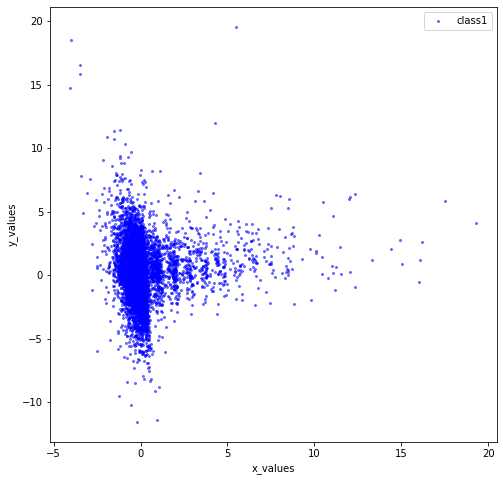

In [97]:
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

#### Performing K-means clustering

['purple', 'orange', 'purple', 'purple', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


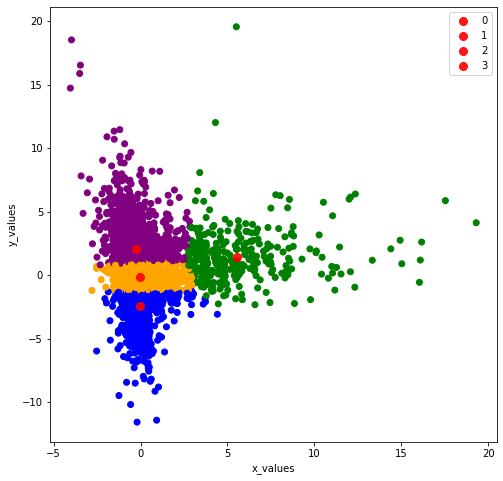

In [101]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

Few clusters

In [106]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds
c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     0.819091
fresh vegetables                 0.738662
packaged vegetables fruits       0.465503
yogurt                           0.278352
packaged cheese                  0.271336
water seltzer sparkling water    0.262774
milk                             0.249903
chips pretzels                   0.205877
soy lactosefree                  0.185660
refrigerated                     0.164669
dtype: float64

In [108]:
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.270228
yogurt                           1.593429
packaged vegetables fruits       1.078006
fresh vegetables                 0.802414
packaged cheese                  0.603487
milk                             0.597228
chips pretzels                   0.481672
water seltzer sparkling water    0.452839
energy granola bars              0.433169
bread                            0.384220
dtype: float64

### xgboost model

In [9]:
data_path = "drive/My Drive/Hackathon/instacart_2017_05_01/"

In [10]:
orders_df = pd.read_csv(data_path + "orders.csv", usecols=["order_id","user_id","order_number"])

In [11]:
orders_df.head(2)

,order_id,user_id,order_number
0,2539329,1,1
1,2398795,1,2


In [30]:
prior_df = pd.read_csv(data_path + "order_products__prior.csv")

In [13]:
prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1


In [31]:
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")

In [32]:
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


Group on the basis of user id and findout the total orders made by the user.

In [33]:
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()

In [34]:
prior_grouped_df.head()

,user_id,order_number
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [35]:
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])

In [36]:
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]

In [37]:
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]

In [38]:
prior_df_latest.head(2)

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0


Group on the basis of  user id and product id to get number of times user have bought the item.

In [39]:
prior_df = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()

In [24]:
prior_df.head(2)

,user_id,product_id,count,sum
0,1,196,10,9
1,1,10258,9,8


In [40]:
prior_df.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]

In [25]:
prior_df.head(2)

,user_id,product_id,count,sum
0,1,196,10,9
1,1,10258,9,8


In [41]:
prior_df = pd.merge(prior_df, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


In [42]:
orders_df.drop(["order_number"],axis=1,inplace=True)

In [43]:
train_df = pd.read_csv(data_path + "order_products__train.csv", usecols=["order_id"])

In [44]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()

In [45]:
test_df = pd.read_csv(data_path + "sample_submission.csv", usecols=["order_id"])

In [46]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")

In [47]:
test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")

In [48]:
print(train_df.shape, test_df.shape)

(131209, 2) (75000, 2)


In [49]:
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [50]:
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


In [51]:
train_df = pd.merge(train_df, prior_df, how="inner", on="user_id")
test_df = pd.merge(test_df, prior_df, how="inner", on="user_id")
# del prior_df, prior_grouped_df, prior_df_latest
print(train_df.shape, test_df.shape)

(8474661, 6) (4833292, 6)


In [52]:
train_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN
...,...,...,...,...,...,...
8474656,3421070,139822,31506,1,0,NaN
8474657,3421070,139822,34035,1,0,NaN
8474658,3421070,139822,35347,1,0,NaN
8474659,3421070,139822,35951,5,4,NaN


In [53]:
test_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0
...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN
4833288,3421054,153585,47145,1,0,NaN
4833289,3421054,153585,47226,1,0,NaN
4833290,3421054,153585,48790,2,1,NaN


In [54]:
products_df = pd.read_csv(data_path + "products.csv", usecols=["product_id", "aisle_id", "department_id"])
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
# del products_df
print(train_df.shape, test_df.shape)

(8474661, 8) (4833292, 8)


In [55]:
train_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19
...,...,...,...,...,...,...,...,...
8474656,3417483,88512,13705,1,0,NaN,109,11
8474657,3418547,187144,22747,1,0,NaN,37,1
8474658,3418573,117202,25184,2,1,NaN,44,11
8474659,3419273,47713,38623,2,1,NaN,4,9


In [56]:
train_y_df = pd.read_csv(data_path + "order_products__train.csv", usecols=["order_id", "product_id", "reordered"])

In [57]:
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")

In [58]:
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]

In [ ]:
train_y_df

,user_id,product_id,reordered
0,112108,49302,1
1,112108,11109,1
2,112108,10246,0
3,112108,49683,0
4,112108,43633,1
...,...,...,...
1384612,169679,14233,1
1384613,169679,35548,1
1384614,139822,35951,1
1384615,139822,16953,1


In [59]:
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


In [ ]:
train_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered
0,1,112108,2067,1,0,NaN,3,19,0.0
1,96,17227,2067,1,0,NaN,3,19,0.0
2,3243,206024,2067,1,0,NaN,3,19,0.0
3,12950,11456,2067,1,0,0.0,3,19,0.0
4,17683,177724,2067,1,0,NaN,3,19,0.0
...,...,...,...,...,...,...,...,...,...
8474656,3417483,88512,13705,1,0,NaN,109,11,0.0
8474657,3418547,187144,22747,1,0,NaN,37,1,0.0
8474658,3418573,117202,25184,2,1,NaN,44,11,0.0
8474659,3419273,47713,38623,2,1,NaN,4,9,0.0


In [60]:
train_df['reordered'].value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [ ]:
del train_y_df

In [61]:
train_y = train_df.reordered.values
out_df = test_df[["order_id", "product_id"]]

In [ ]:
out_df.shape

(4833292, 2)

In [62]:
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

(8474661, 6) (4833292, 6)


In [ ]:
train_df

array([[2.0670e+03, 1.0000e+00, 0.0000e+00,        nan, 3.0000e+00,
        1.9000e+01],
       [2.0670e+03, 1.0000e+00, 0.0000e+00,        nan, 3.0000e+00,
        1.9000e+01],
       [2.0670e+03, 1.0000e+00, 0.0000e+00,        nan, 3.0000e+00,
        1.9000e+01],
       ...,
       [2.5184e+04, 2.0000e+00, 1.0000e+00,        nan, 4.4000e+01,
        1.1000e+01],
       [3.8623e+04, 2.0000e+00, 1.0000e+00,        nan, 4.0000e+00,
        9.0000e+00],
       [2.2080e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.2100e+02,
        1.4000e+01]])

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y, model

In [63]:
test = xgb.DMatrix(test_df)

In [ ]:
pred_test = model.predict(test)

In [ ]:
test_df.shape

(4833292, 6)

In [ ]:
pred,model = runXGB(train_df, train_y, test_df)
# del train_df, test_df
model.save(data_path + 'xgboost_100.model')
# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df[out_df["Pred"].astype('int')==1]

In [ ]:
model.save_model(data_path + 'xgboost_100.model')

In [ ]:
cutoff = 0.
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df[out_df["Pred"].astype('int')==1]

array([0.14638878, 0.14638878, 0.14638878, ..., 0.17146042, 0.13731982,
       0.13147962], dtype=float32)

In [65]:
new_model = xgb.Booster() 

In [67]:
new_model.load_model(data_path + "xgboost_100.model")

In [69]:
new_model.predict(test)

array([0.04802879, 0.04802879, 0.04802879, ..., 0.06942067, 0.03404874,
       0.02436683], dtype=float32)

In [71]:
pred_new = new_model.predict(test)

In [ ]:
pred_new.shape

(4833292,)

In [ ]:
out_df.shape

(1206149, 3)

In [72]:
cutoff = 0.2
pred_new[pred_new>=cutoff] = 1
pred_new[pred_new<cutoff] = 0
out_df["Pred"] = pred_new
# out_df = out_df[out_df["Pred"].astype('int')==1]

In [73]:
new_out = out_df[out_df["Pred"] == 1]
new_out

,order_id,product_id,Pred
5,1559724,1283,1.0
27,178755,6291,1.0
35,305184,6291,1.0
39,352762,6291,1.0
43,381159,6291,1.0
...,...,...,...
4833241,3369509,17651,1.0
4833259,3378478,7382,1.0
4833264,3394676,13053,1.0
4833282,3412433,18835,1.0


References : 
Multiple submissions in instacrt kaggle competition.
